In [34]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pickle
import re

In [35]:
transcripts_dir = '/Users/akshaykekuda/Desktop/CSR-SA/manual_score_transcriptions/single_ch/'

In [36]:
def prepare_score_df(path_to_p, workgroup):
    with open(path_to_p, 'rb') as file:
        df = pickle.load(file)
    df = df.sort_values(by=['RecordingDate', 'QGroupSequence', 'QuestionSequence']).copy()
    cols = ['QGroupSequence', 'QGroupName', 'InteractionIdKey', 'QuestionSequence', 'QuestionText', 'QuestionType',
            'QuestionPromptType', 'QuestionWeight', 'QuestionMin', 'QuestionMax', 'AnswerScore', 'RawAnswer',
            'DisplayAnswer',
            'UserComments']
    if workgroup == 'all':
        calls_df = df[(df.QuestionnaireName == 'Call Interaction') & ((df.WorkgroupQueue == 'Customer Service') 
                                                                      |(df.WorkgroupQueue == 'Sales'))].copy()
    elif workgroup == 'CustomerService':
        calls_df = df[(df.QuestionnaireName == 'Call Interaction') & (df.WorkgroupQueue == 'Customer Service')].copy()
    elif workgroup == 'Sales':
        calls_df = df[(df.QuestionnaireName == 'Call Interaction') & (df.WorkgroupQueue == 'Sales')].copy()

    q_df = calls_df[cols]
    temp = q_df[0:10]
    temp = temp.reset_index(drop=True)
    q_text = []
    for index, row in temp.iterrows():
        q_text.append(row['QuestionText'])

    score_df = pd.DataFrame()
    score_df['WorkgroupQueue'] = calls_df.WorkgroupQueue[::10]
    score_df['RecordingDate'] = calls_df.RecordingDate[::10]
    # change baseline score range accordingly
    # overall score between 0 and 1
    score_df['CombinedPercentileScore'] = (calls_df.CombinedPercentileScore[::10]/100).astype(float).round(4)
    score_df['Category'] = (score_df['CombinedPercentileScore'] < 0.75).apply(lambda x: int(x))
    # overall score between 0 and 100
    # score_df['CombinedPercentileScore'] = (calls_df.CombinedPercentileScore[::10]).astype(float).round(2)
    # score_df['Category'] = (score_df['CombinedPercentileScore'] > 75).apply(lambda x: int(x))
    score_df.index = calls_df.InteractionIdKey[::10]
    calls_df.AnswerScore = calls_df.AnswerScore.astype('int')
    for i in range(10):
        criteria = q_text[i]
        q_max = int(calls_df.QuestionMax.iloc[i])
        score_df[criteria] = (calls_df.AnswerScore[i::10]).values
        score_df[criteria] = score_df[criteria].apply(lambda x: 0 if x >= q_max else 1) #used as binary class
        # score_df[criteria] = score_df[criteria].apply(lambda x: 1 if x >= q_max else 0) #used as binary class
        score_df[criteria + ' Feedback'] = (calls_df.UserComments[i::10]).values
    score_df = score_df.loc[~score_df.index.duplicated(keep='last')]
    print("Dataframe creation done")

    return score_df, q_text


def prepare_trancript_score_df(score_df, q_text, transcripts_dir):
    df = pd.DataFrame(columns=['text', 'file_name'])
    for file in os.listdir(transcripts_dir):
        if file.endswith('.txt'):
            file_loc = transcripts_dir + file
            f = open(file_loc, 'r')
            tscpt = f.read()
            f.close()
            if len(tscpt) == 0:
                print("empty file")
                continue
            id = re.split("_|-|\.", file)[1]
            if id in score_df.index:
                    df.loc[id, score_df.columns] = score_df.loc[id]
                    df.loc[id, ['text', 'file_name']] = [tscpt, file_loc]
    df.loc[:, q_text] = df.loc[:, q_text].astype(int)
    df = df[df['text'].notna()]
    print("Number of Calls = {}".format(len(df)))
    return df


def balance_df(df, num_samples):
    h = df[df.Category == 1].sample(n=num_samples//2)
    l = df[df.Category == 0].sample(n=num_samples//2)
    df_sampled = pd.concat((h,l))
    print("sampled df:", df_sampled.Category.value_counts())
    # h = len(df[df.Category == 1])
    # l = len(df) - h
    # temp = df[df.Category == 1].sample(h -l).index
    # df_sampled = df.drop(temp)
    # print('training and dev sample size = {} good ={} bad ={}'.format(len(df_sampled),l,l))
    # print('test sample size = {}'.format(len(df.loc[temp])))
    # remaining = df.index.difference(temp, sort=False)
    return df_sampled

In [37]:
score_df, q_text = prepare_score_df("/Users/akshaykekuda/Desktop/CSR-SA/attention_model/ScoringDetail_viw_all_subscore.p", 'all')

Dataframe creation done


In [5]:
len(score_df)

22379

In [6]:
score_df.WorkgroupQueue.value_counts()

Sales               12942
Customer Service     9437
Name: WorkgroupQueue, dtype: int64

In [7]:
score_df

,WorkgroupQueue,RecordingDate,CombinedPercentileScore,Category,Greeting,Greeting Feedback,Professionalism,Professionalism Feedback,Confidence,Confidence Feedback,...,Creates Incentive,Creates Incentive Feedback,Product Knowledge,Product Knowledge Feedback,Education,Education Feedback,Documentation,Documentation Feedback,Processes,Processes Feedback
InteractionIdKey,,,,,,,,,,,,,,,,,,,,,
200122372070190416,Sales,2019-04-16 12:15:51.133,0.8462,0,0,None,0,None,0,None,...,1,"Asked for the sale. However, did not confirm i...",0,None,0,None,0,None,1,Did not verify if there were excluded drivers
200125131970190416,Sales,2019-04-16 17:46:44.210,0.6410,1,0,Testing - Agent used proper greeting,0,Agent was professional,1,Agent used they statements.,...,1,Created incentive to buy.,0,Demonstrated product knowledge for options off...,0,Provided accurate education,1,Did not properly document policy.,0,Read all disclosured and followed all steps wi...
200140876070190419,Sales,2019-04-19 14:44:43.227,0.6154,1,1,took 43 seconds to answer,0,None,0,None,...,1,The customer lived in FL and once provided wit...,0,None,0,None,0,None,1,There was no attempt to overcome the rate obje...
200140954270190419,Sales,2019-04-19 14:52:37.793,0.6410,1,1,It took 9 seconds to answer the call,0,None,1,None,...,0,None,0,Did not properly educate about the Renter's In...,1,Did not properly educate about the Renter's In...,0,None,1,Did not verify the PH#
200163786670190424,Sales,2019-04-24 19:58:33.140,0.4103,1,0,None,0,- Good Job using Thank you throughout the call...,1,- You were very solid with your questions - Be...,...,1,- Incentive the customer to purchase the pol. ...,1,- This goes hand and hand with Cross-selling. ...,1,- MVR Disclosure was not read - Not properly e...,0,None,1,- You should be reading the Non-Owner's pop up...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300115056920210826,Customer Service,2021-08-25 23:09:59.753,0.8718,0,0,None,0,None,0,we place customer for hold over 7min 29sec. re...,...,0,None,0,None,0,None,0,None,1,We did not verify the customers phone and it d...
300115088620210826,Customer Service,2021-08-26 00:00:26.660,0.9744,0,0,None,0,None,1,Dead air from min 1:05-2:20,...,0,None,0,None,0,None,0,None,0,None
300115956220210826,Sales,2021-08-26 09:41:12.800,1.0000,0,0,None,0,None,0,None,...,0,None,0,None,0,None,0,None,0,None


In [8]:
A = score_df[score_df.WorkgroupQueue == 'Sales']

In [9]:
all_sales = A.index

In [10]:
file = open("all_sales.txt", 'w')
for id in all_sales:
    file.write(id+'\n')
file.close()

In [11]:
transcript_score_df = prepare_trancript_score_df(score_df, q_text, transcripts_dir)

empty file
Number of Calls = 13891


In [12]:
A = score_df[score_df.WorkgroupQueue == 'Sales']
B = transcript_score_df[transcript_score_df.WorkgroupQueue == 'Sales']
new_sales = set(A.index) - set(B.index)

In [13]:
len(B)

11614

In [14]:
len(new_sales)

1328

In [15]:
file = open("all_sales.txt", 'w')
for id in all_sales:
    file.write(id+'\n')
file.close()

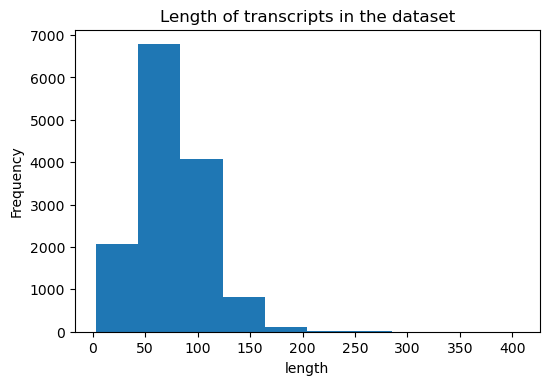

In [16]:
plt.figure(figsize=(6,4),dpi=100)
transcript_score_df.text.apply(lambda x: len(x.split('\n'))).plot.hist()
plt.title("Length of transcripts in the dataset")
plt.xlabel("length")
plt.show()

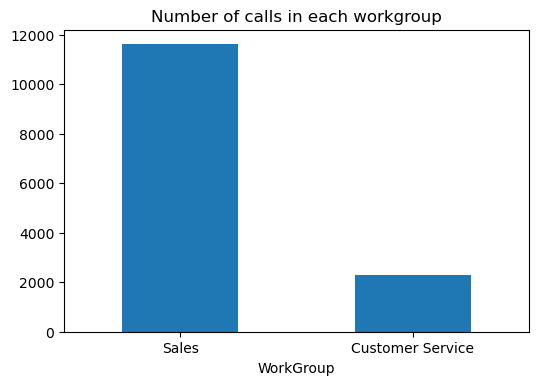

In [17]:
plt.figure(figsize=(6,4),dpi=100)
transcript_score_df.WorkgroupQueue.value_counts().plot.bar()
plt.title("Number of calls in each workgroup")
plt.xlabel("WorkGroup")
plt.xticks(rotation = 0) # Rotates X-Axis Ticks by 45-degrees
plt.show()

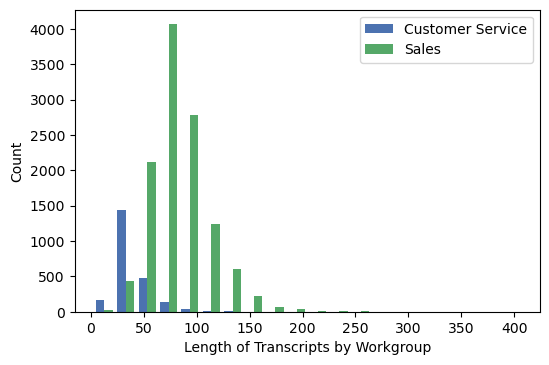

In [18]:
cs_df = transcript_score_df[transcript_score_df['WorkgroupQueue'] == 'Customer Service']
sales_df = transcript_score_df[transcript_score_df['WorkgroupQueue'] == 'Sales']
x= cs_df.text.apply(lambda x: len(x.split("\n")))
y = sales_df.text.apply(lambda x: len(x.split("\n")))
plt.figure(figsize = (6,4), dpi=100)
plt.style.use('seaborn-deep')
plt.hist([x, y], bins=20, label=['Customer Service', 'Sales'])
plt.legend(loc='upper right')
plt.xlabel("Length of Transcripts by Workgroup")
plt.ylabel("Count")
plt.show()

In [19]:
score_df[q_text].apply(pd.value_counts).T

,0,1
Greeting,21823,556
Professionalism,21549,830
Confidence,20399,1980
Cross Selling,13364,9015
Retention,20677,1702
Creates Incentive,14280,8099
Product Knowledge,20364,2015
Education,15014,7365
Documentation,20170,2209
Processes,13002,9377


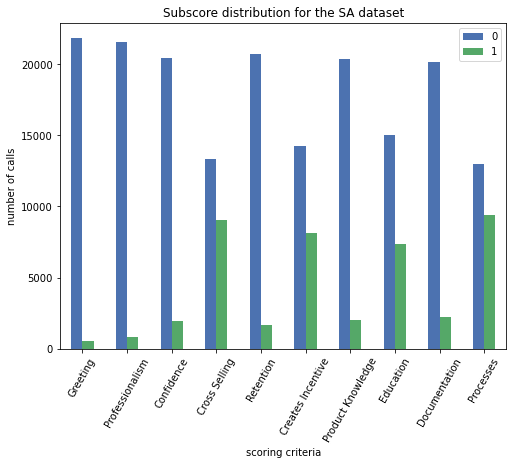

In [20]:
score_df[q_text].apply(pd.value_counts).T.plot.bar(rot=60, figsize=(8,6), 
                                xlabel="scoring criteria", ylabel="number of calls")
plt.title("Subscore distribution for the SA dataset")
plt.legend()
plt.show()

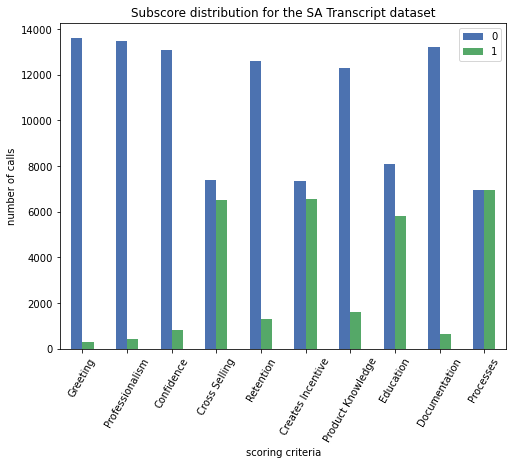

In [21]:
transcript_score_df[q_text].apply(pd.value_counts).T.plot.bar(rot=60, figsize=(8,6), 
                                xlabel="scoring criteria", ylabel="number of calls")
plt.title("Subscore distribution for the SA Transcript dataset")
plt.legend()
plt.show()

In [22]:
needed = ['Cross Selling','Creates Incentive', 'Product Knowledge', 'Education', 'Processes']
x = [False for i in range(len(transcript_score_df))]
for cat in needed:
    x = (transcript_score_df[cat]==0) | x

In [23]:
curr_idx=transcript_score_df[x].index

In [24]:
x = [False for i in range(len(score_df))]
for cat in needed:
    x = (score_df[cat]==0) | x

In [25]:
score_df[x]

,WorkgroupQueue,RecordingDate,CombinedPercentileScore,Category,Greeting,Greeting Feedback,Professionalism,Professionalism Feedback,Confidence,Confidence Feedback,...,Creates Incentive,Creates Incentive Feedback,Product Knowledge,Product Knowledge Feedback,Education,Education Feedback,Documentation,Documentation Feedback,Processes,Processes Feedback
InteractionIdKey,,,,,,,,,,,,,,,,,,,,,
200122372070190416,Sales,2019-04-16 12:15:51.133,0.8462,0,0,None,0,None,0,None,...,1,"Asked for the sale. However, did not confirm i...",0,None,0,None,0,None,1,Did not verify if there were excluded drivers
200125131970190416,Sales,2019-04-16 17:46:44.210,0.6410,1,0,Testing - Agent used proper greeting,0,Agent was professional,1,Agent used they statements.,...,1,Created incentive to buy.,0,Demonstrated product knowledge for options off...,0,Provided accurate education,1,Did not properly document policy.,0,Read all disclosured and followed all steps wi...
200140876070190419,Sales,2019-04-19 14:44:43.227,0.6154,1,1,took 43 seconds to answer,0,None,0,None,...,1,The customer lived in FL and once provided wit...,0,None,0,None,0,None,1,There was no attempt to overcome the rate obje...
200140954270190419,Sales,2019-04-19 14:52:37.793,0.6410,1,1,It took 9 seconds to answer the call,0,None,1,None,...,0,None,0,Did not properly educate about the Renter's In...,1,Did not properly educate about the Renter's In...,0,None,1,Did not verify the PH#
200175177170190426,Sales,2019-04-26 17:49:12.020,0.5897,1,0,None,0,None,0,None,...,1,"- After providing quote, no benefits were offe...",1,- We did not ask if customer would be interest...,0,None,0,None,1,- Additional HH members were not disclosed/fou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300115056920210826,Customer Service,2021-08-25 23:09:59.753,0.8718,0,0,None,0,None,0,we place customer for hold over 7min 29sec. re...,...,0,None,0,None,0,None,0,None,1,We did not verify the customers phone and it d...
300115088620210826,Customer Service,2021-08-26 00:00:26.660,0.9744,0,0,None,0,None,1,Dead air from min 1:05-2:20,...,0,None,0,None,0,None,0,None,0,None
300115956220210826,Sales,2021-08-26 09:41:12.800,1.0000,0,0,None,0,None,0,None,...,0,None,0,None,0,None,0,None,0,None


In [26]:
cross = transcript_score_df[transcript_score_df['Cross Selling']==0]
ci = transcript_score_df[transcript_score_df['Creates Incentive']==0]
pd = transcript_score_df[transcript_score_df['Product Knowledge']==0]
ed= transcript_score_df[transcript_score_df['Education']==0]
pr = transcript_score_df[transcript_score_df['Processes']==0]

In [27]:
len(set(cross, ci, pd, ed, pr))

TypeError: set expected at most 1 argument, got 5

In [ ]:
# plt.figure(figsize = (8,8), dpi=100)
plt.hist(df['CombinedPercentileScore'].values, bins =10)
plt.show()

In [ ]:
bad_calls = df[df['CombinedPercentileScore'] < 70]
good_calls = df[df['CombinedPercentileScore'] >= 70]
scoring_att = bad_calls.columns[-10:]
fig, axes = plt.subplots(5, 2, figsize=(10, 18))
fig.suptitle('Subscore Counts')
for i in range(10):
    row = i //2
    col = i%2
    sns.countplot(ax=axes[row, col], data=bad_calls, x=scoring_att[i])

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(18, 18))
fig.suptitle('Subscore Counts')
for i in range(10):
    row = i //2
    col = i%2
    sns.countplot(ax=axes[row, col], data=good_calls, x=scoring_att[i])

In [ ]:
id_list = df[(df.RecordingDate > '2020-06-01') & (df.RecordingDate <'2021-01-01')].index.tolist()[:5000]
file = open('pull_call_ids', 'w')
for id in id_list:
    file.write('{}\n'.format(id))

In [ ]:
subscores = df.iloc[:, -10:]
subscores['Combined_Percentile'] = df.CombinedPercentileScore
scaler = MinMaxScaler()
subscores_norm = pd.DataFrame(scaler.fit_transform(subscores), columns=subscores.columns)

In [ ]:
plt.figure(figsize=(8,8), dpi=100)
sns.heatmap(subscores.corr(), annot=True)
plt.show()

In [ ]:
transcript_score_df = prepare_trancript_score_df(df)

In [ ]:
transcript_score_df = transcript_score_df.drop(columns=['RecordingDate', 'Category'])
transcript_score_df['SoftSkills'] = transcript_score_df.iloc[:,4:7].sum(axis=1)
transcript_score_df['CustomerNeed'] = transcript_score_df.iloc[:,7:11].sum(axis=1)
transcript_score_df['Accuracy'] = transcript_score_df.iloc[:,11:14].sum(axis=1)

In [ ]:
plt.figure(figsize=(12,12), dpi=100)
sns.heatmap(transcript_score_df.corr(), annot=True)
plt.title("Correlation between labels for transcript call dataset")
plt.show()

In [ ]:
all_df, q_text = prepare_score_df("/Users/akshaykekuda/Desktop/CSR-SA/ScoringDetail_viw_all_subscore.p")

In [ ]:
all_subscores = all_df.drop(columns=['RecordingDate', 'Category'])
all_subscores['SoftSkills'] = all_subscores.iloc[:,2:5].sum(axis=1)
all_subscores['CustomerNeed'] = all_subscores.iloc[:,5:9].sum(axis=1)
all_subscores['Accuracy'] = all_subscores.iloc[:,9:12].sum(axis=1)

In [ ]:
plt.figure(figsize=(12,12), dpi=100)
sns.heatmap(all_subscores.corr(), annot=True)
plt.title("Correlation between labels for all call dataset")
plt.show()

In [ ]:
plt.figure(figsize=(12,12), dpi=100)
sns.heatmap(all_subscores.corr(), annot=True)
plt.title("Correlation between labels for all call dataset")
plt.show()

In [ ]:
sales_df = all_subscores[all_subscores.WorkgroupQueue == 'Sales']
plt.figure(figsize=(12,12), dpi=100)
sns.heatmap(sales_df.corr(), annot=True)
plt.title("Correlation between labels for all Sales call dataset")
plt.show()

In [ ]:
cs_df = all_subscores[all_subscores.WorkgroupQueue == 'Customer Service']
plt.figure(figsize=(12,12), dpi=100)
sns.heatmap(cs_df.corr(), annot=True)
plt.title("Correlation between labels for all Customer Service call dataset")
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,8), dpi=100)
for i, thresh in enumerate([40, 60, 70, 90]):
    row = i//2
    col = i%2
    transcript_score_df['Category'] = (transcript_score_df['CombinedPercentileScore']>thresh).apply(lambda x:int(x))
    ax[row, col] = sns.countplot(data=transcript_score_df, x='Category', hue='WorkgroupQueue', ax=ax[row, col], )
    ax[row, col].get_legend().remove()
    ax[row, col].tick_params(axis='x', rotation=45)
    ax[row, col].set_title("Threshold ={}".format(thresh))
ax[0,0].legend(fontsize = 9, loc="upper left")
fig.suptitle("Distribution of calls per WorkGroup for the HAN model")
fig.tight_layout()

In [ ]:
group_df=transcript_score_df.groupby(['Cross Selling', 'WorkgroupQueue', 'Category']).size().unstack()
group_df

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,8), dpi=100)
for i, thresh in enumerate([40, 60, 70, 90]):
    row = i//2
    col = i%2
    transcript_score_df['Category'] = (transcript_score_df['CombinedPercentileScore']>thresh).apply(lambda x:int(x))
    group_df = transcript_score_df.groupby(['Cross Selling']).size()
    ax[row, col] = sns.countplot(data=transcript_score_df, x='Cross Selling', hue='Category', ax=ax[row, col], )
    ax[row, col].get_legend().remove()
    ax[row, col].tick_params(axis='x', rotation=45)
    ax[row, col].set_title("Threshold ={}".format(thresh))
ax[0,0].legend(fontsize = 9, loc="upper left", title='Bad/Good Call')
fig.suptitle("Distribution of calls for cross selling category for the HAN model")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,8), dpi=100)
for i, thresh in enumerate([60, 70, 80, 90]):
    row = i//2
    col = i%2
    transcript_score_df['Category'] = (transcript_score_df['CombinedPercentileScore']>thresh).apply(lambda x:int(x))
    group_df = transcript_score_df.groupby(['Cross Selling']).size()
    ax[row, col] = sns.countplot(data=transcript_score_df, hue='Cross Selling', x='Category', ax=ax[row, col], )
    ax[row, col].get_legend().remove()
    ax[row, col].tick_params(axis='x', rotation=45)
    ax[row, col].set_title("Threshold ={}".format(thresh))
ax[0,0].legend(fontsize = 9, loc="upper left", title='Cross Selling Score')
fig.suptitle("Distribution of Cross Selling score for the HAN model")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,6), dpi=100)
for i, thresh in enumerate([60, 70, 80, 90]):
    row = i//2
    col = i%2
    transcript_score_df['Category'] = (transcript_score_df['CombinedPercentileScore']>thresh).apply(lambda x:int(x))
    ax[row, col] = sns.countplot(data=transcript_score_df, x='Category', hue ='Professionalism', ax=ax[row, col], )
    ax[row, col].get_legend().remove()
    ax[row, col].tick_params(axis='x', rotation=45)
    ax[row, col].set_title("Threshold ={}".format(thresh))
ax[0,0].legend(fontsize = 6, loc="upper left", title='Professionalism Score')
fig.suptitle("Distribution of Professioanlism score for the HAN model")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,6), dpi=100)
for i, thresh in enumerate([60, 70, 80, 90]):
    row = i//2
    col = i%2
    all_subscores['Category'] = (all_subscores['CombinedPercentileScore']>thresh).apply(lambda x:int(x))
    ax[row, col] = sns.countplot(data=all_subscores, x='Category', hue ='Professionalism', ax=ax[row, col], )
    ax[row, col].get_legend().remove()
    ax[row, col].tick_params(axis='x', rotation=45)
    ax[row, col].set_title("Threshold ={}".format(thresh))
ax[0,0].legend(fontsize = 6, loc="upper left", title='Professionalism Score')
fig.suptitle("Distribution of Professioanalism score in the entire dataset")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,6), dpi=100)
for i, thresh in enumerate([60, 70, 80, 90]):
    row = i//2
    col = i%2
    all_subscores['Category'] = (all_subscores['CombinedPercentileScore']>thresh).apply(lambda x:int(x))
    ax[row, col] = sns.countplot(data=all_subscores, x='Category', hue ='Cross Selling', ax=ax[row, col], )
    ax[row, col].get_legend().remove()
    ax[row, col].tick_params(axis='x', rotation=45)
    ax[row, col].set_title("Threshold ={}".format(thresh))
ax[0,0].legend(fontsize = 6, loc="upper left", title='Professionalism Score')
fig.suptitle("Distribution of Cross Selling score in the entire dataset")
fig.tight_layout()

In [ ]:
cs_df = all_subscores[all_subscores.WorkgroupQueue == 'Customer Service']
plt.figure(figsize=(6,4), dpi=100)
sns.distplot(all_subscores.CombinedPercentileScore)
plt.title("Distribution of combined percentile scores")
plt.show()

In [ ]:
all_df.head()

In [ ]:
id_list = all_df[(all_df.RecordingDate <'2021-01-01') & (all_df.Professionalism ==0) & (all_df['Cross Selling'] ==0) &
                (all_df['Product Knowledge']==0)]

In [ ]:
id_list = all_df[(all_df.RecordingDate <'2021-01-01') & 
                 ((all_df.CombinedPercentileScore <60) | (all_df['Product Knowledge']==0))]
temp = pd.concat((id_list, transcript_score_df), axis=0)
fig, axes = plt.subplots(5, 2, figsize=(10, 18))
fig.suptitle('Subscore Counts')
for i in range(10):
    row = i //2
    col = i%2
    sns.countplot(ax=axes[row, col], data=temp, x=q_text[i])
fig.tight_layout()

In [ ]:
file = open('pull_call_ids', 'w')
for id in id_list.index.tolist():
    file.write('{}\n'.format(id))

# Sales Calls Feedback Analysis

In [28]:
score_df

,WorkgroupQueue,RecordingDate,CombinedPercentileScore,Category,Greeting,Greeting Feedback,Professionalism,Professionalism Feedback,Confidence,Confidence Feedback,...,Creates Incentive,Creates Incentive Feedback,Product Knowledge,Product Knowledge Feedback,Education,Education Feedback,Documentation,Documentation Feedback,Processes,Processes Feedback
InteractionIdKey,,,,,,,,,,,,,,,,,,,,,
200122372070190416,Sales,2019-04-16 12:15:51.133,0.8462,0,0,None,0,None,0,None,...,1,"Asked for the sale. However, did not confirm i...",0,None,0,None,0,None,1,Did not verify if there were excluded drivers
200125131970190416,Sales,2019-04-16 17:46:44.210,0.6410,1,0,Testing - Agent used proper greeting,0,Agent was professional,1,Agent used they statements.,...,1,Created incentive to buy.,0,Demonstrated product knowledge for options off...,0,Provided accurate education,1,Did not properly document policy.,0,Read all disclosured and followed all steps wi...
200140876070190419,Sales,2019-04-19 14:44:43.227,0.6154,1,1,took 43 seconds to answer,0,None,0,None,...,1,The customer lived in FL and once provided wit...,0,None,0,None,0,None,1,There was no attempt to overcome the rate obje...
200140954270190419,Sales,2019-04-19 14:52:37.793,0.6410,1,1,It took 9 seconds to answer the call,0,None,1,None,...,0,None,0,Did not properly educate about the Renter's In...,1,Did not properly educate about the Renter's In...,0,None,1,Did not verify the PH#
200163786670190424,Sales,2019-04-24 19:58:33.140,0.4103,1,0,None,0,- Good Job using Thank you throughout the call...,1,- You were very solid with your questions - Be...,...,1,- Incentive the customer to purchase the pol. ...,1,- This goes hand and hand with Cross-selling. ...,1,- MVR Disclosure was not read - Not properly e...,0,None,1,- You should be reading the Non-Owner's pop up...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300115056920210826,Customer Service,2021-08-25 23:09:59.753,0.8718,0,0,None,0,None,0,we place customer for hold over 7min 29sec. re...,...,0,None,0,None,0,None,0,None,1,We did not verify the customers phone and it d...
300115088620210826,Customer Service,2021-08-26 00:00:26.660,0.9744,0,0,None,0,None,1,Dead air from min 1:05-2:20,...,0,None,0,None,0,None,0,None,0,None
300115956220210826,Sales,2021-08-26 09:41:12.800,1.0000,0,0,None,0,None,0,None,...,0,None,0,None,0,None,0,None,0,None


In [38]:
sales = score_df[score_df.WorkgroupQueue == 'Sales']

In [39]:
df = pd.DataFrame()
df['Creates Incentive Feedback'] = sales['Creates Incentive Feedback'].dropna()
df['CI Score'] = sales.loc[df.index]['Creates Incentive']

In [40]:
df[df['CI Score']==1]

,Creates Incentive Feedback,CI Score
InteractionIdKey,,
200122372070190416,"Asked for the sale. However, did not confirm i...",1
200125131970190416,Created incentive to buy.,1
200140876070190419,The customer lived in FL and once provided wit...,1
200163786670190424,- Incentive the customer to purchase the pol. ...,1
200175177170190426,"- After providing quote, no benefits were offe...",1
...,...,...
200199250830210823,Carla completed the quote using ITC and she co...,1
300100245730210823,Good job providing the customer her payment op...,1
300100453730210823,"Chenicka did a good job asking for the sale, m...",1


In [41]:
df['feedback']= df['Creates Incentive Feedback'].str.split().apply(lambda x: ' '.join(x))

In [42]:
df = df.drop(columns='Creates Incentive Feedback')

In [43]:
df

,CI Score,feedback
InteractionIdKey,,
200122372070190416,1,"Asked for the sale. However, did not confirm i..."
200125131970190416,1,Created incentive to buy.
200140876070190419,1,The customer lived in FL and once provided wit...
200163786670190424,1,- Incentive the customer to purchase the pol. ...
200175177170190426,1,"- After providing quote, no benefits were offe..."
...,...,...
300108917020210824,0,No way to create incentive here. Customer want...
300109007820210824,0,"Great job by asking for the sale, and giving i..."
300109500020210825,0,Tammy did a good job asking for the salea and ...


In [44]:
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords  #stopwords
from nltk.stem import WordNetLemmatizer 
stop_words=set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshaykekuda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akshaykekuda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
def clean_text(text):
    le=WordNetLemmatizer()
    word_tokens=word_tokenize(text)
    tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
    cleaned_text=" ".join(tokens)
    return cleaned_text.lower()

In [46]:
df['clean_text'] = df.feedback.apply(lambda x: clean_text(x))

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
vect =TfidfVectorizer(stop_words=stop_words, max_features=500)
vect_text=vect.fit_transform(df[df['CI Score']==1]['clean_text'])

In [58]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=20,
learning_method='online',random_state=42,max_iter=5) 
lda_top=lda_model.fit_transform(vect_text)

In [59]:
vect_text.shape

(6709, 500)

In [60]:
vocab = vect.get_feature_names()
for i, comp in enumerate(lda_model.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
            print(t[0],end=" ")
     print('\n')
     for t in sorted_words:
            print(t[1],end=" ")
            
     print('\n')

Topic 0: 
purchase discount well sent mention applicable added proof incentive offer 

96.95847503658261 82.18267447640845 70.08364807006795 60.95014593227348 54.3112913622998 52.990465796291446 45.65673209451273 36.194428953734366 33.46005756708573 31.204142755588705 

Topic 1: 
start missed offer policy previous insurance failed incentive creates sale 

91.6236797009654 81.9359674972021 60.8430850313685 53.97235308475986 53.64433439017998 46.83359600108431 44.38247364538484 39.602105535132246 36.792581859263784 26.728425563862718 

Topic 2: 
verify know option customer selina discount payment mary tammy completed 

34.086335360790805 24.838892955277757 24.11414421377603 23.052748066235026 19.93612396103259 18.786272490706157 18.303409193847365 16.273508833419676 14.78899856346671 14.704915206766561 

Topic 3: 
sell right provide started away however discount example rate verify 

83.13716325721069 54.18178445036331 53.744171837699476 51.13627232393717 49.85157788194917 46.16975033059

/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [56]:
lda_model.

(20, 1406)

In [ ]:
pip install bertopic

In [48]:
pip install hdbscan

You should consider upgrading via the '/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [50]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(vect_text)

ImportError: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/hdbscan/_hdbscan_linkage.cpython-39-darwin.so, 0x0002): tried: '/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/hdbscan/_hdbscan_linkage.cpython-39-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e')), '/usr/local/lib/_hdbscan_linkage.cpython-39-darwin.so' (no such file), '/usr/lib/_hdbscan_linkage.cpython-39-darwin.so' (no such file)